<a href="https://colab.research.google.com/github/gyasifred/msc-thesis/blob/main/twi_french_seq2seq_nmt_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This exercise will demonstrate how to build sequence to sequence models with attention for Twi-French machine translation. This code is based on the tensorflow implementation of the paper [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5) (Luong et al., 2015).The code snippet are adapted from from [[1]](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

# Import Tensorflow

In [ ]:
!pip install "tensorflow-text==2.8.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 3.7 MB/s 


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# Preprocess data

In [ ]:
# This code was adapted from https://github.com/GhanaNLP/kasa/blob/master/Kasa/Preprocessing.py
# import required library
import re
import unicodedata


class Preprocessing:
    # dummy initialization method
    def __init__(self):
        # initialize with some default parameters here later
        pass

    # read in parallel twi - french dataset
    def read_parallel_dataset(self, filepath_twi, filepath_french):

        # read french data
        french_data = []
        with open(filepath_french, encoding='utf-8') as file:
            line = file.readline()
            cnt = 1
            while line:
                french_data.append(line.strip())
                line = file.readline()
                cnt += 1

        # read twi data
        twi_data = []
        with open(filepath_twi, encoding='utf-8') as file:

            # twi=file.read()
            line = file.readline()
            cnt = 1
            while line:
                twi_data.append(line.strip())
                line = file.readline()
                cnt += 1

        return twi_data, french_data

    # Define a helper function to remove string accents

    def removeStringAccent(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )

    # normalize input twi sentence
    def normalize_twi(self, s):
        s = self.removeStringAccent(s)
        s = re.sub(r'([!.?])', r' \1', s)
        s = re.sub(r'[^a-zA-Z.ƆɔɛƐ!?’]+', r' ', s)
        s = re.sub(r'\s+', r' ', s)
        return s

    # normalize input french sentence
    def normalize_fr(self, s):
        s = self.removeStringAccent(s)
        s = re.sub(r'([!.?])', r' \1', s)
        s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
        s = re.sub(r'\s+', r' ', s)
        return s

In [ ]:
# Create an instance of tft preprocessing class

TwiFrPreprocessor = Preprocessing()

# Read raw parallel dataset
raw_data_twi,raw_data_fr = TwiFrPreprocessor.read_parallel_dataset(
        filepath_twi='/content/verified_twi.txt',
        filepath_french='/content/verified_french.txt')

# Normalize the raw data
raw_data_fr = [TwiFrPreprocessor.normalize_fr(data) for data in raw_data_fr]
raw_data_twi = [TwiFrPreprocessor.normalize_twi(data) for data in raw_data_twi]

In [ ]:
# define function to write text to txt file
def writeTotxt(destination,data):
  with open(destination, 'w') as f:
    for line in data:
        f.write(f"{line}\n")

In [ ]:
# write the preprocess french and twi lines to a file
writeTotxt('twi_lines.txt',raw_data_twi)
writeTotxt('fr_lines.txt',raw_data_fr)

# Create a Tokenizer

## Build tf Dataset

In [ ]:
full_dataset_fr = tf.data.TextLineDataset('/content/fr_lines.txt')
full_dataset_tw = tf.data.TextLineDataset('/content/twi_lines.txt')


## Text vectorization

In [ ]:
# add start and end tokens
def tf_start_and_end_tokens(text):
    # Split accented characters.
    #text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

# set maximum vocaburary size
max_vocab_size = 10000
# Process twi as input
twi_tokenizer = tf.keras.layers.TextVectorization(
    standardize=tf_start_and_end_tokens,
    max_tokens=max_vocab_size)
twi_tokenizer.adapt(full_dataset_tw)

# Process french as output
french_tokenizer = tf.keras.layers.TextVectorization(
    standardize=tf_start_and_end_tokens,
    max_tokens=max_vocab_size)

french_tokenizer.adapt(full_dataset_fr)

In [ ]:
# Print few lines of our tokenizers vocabulary and length
print(f'French Tokenizer:',french_tokenizer.get_vocabulary()[:10])
print(f'French Tokenizer size:',len(french_tokenizer.get_vocabulary()))

print()
print(f'TWI Tokenizer:',twi_tokenizer.get_vocabulary()[-10:])
print(f'TWI Tokenizer size:',len(twi_tokenizer.get_vocabulary()))


French Tokenizer: ['', '[UNK]', '[START]', '[END]', '.', 'a', 'de', 'je', 'est', 'il']
French Tokenizer size: 9570

TWI Tokenizer: ['abamu', 'abambu', 'abada', 'abaafo', 'aakwantuo', 'aa', '.r', '.meda', '.ma', '.abena']
TWI Tokenizer size: 7750


# Create Train and Test sets

In [ ]:
# split the dataset into training and test sets
# Keep 20% of the data as test set
train_twi,test_twi,train_fr,test_fr = train_test_split(raw_data_twi,raw_data_fr, test_size=0.2, random_state=42)

In [ ]:
# write the preprocess traning and test dataset to a file
writeTotxt('train_twi.txt',train_twi)
writeTotxt('train_fr.txt',train_fr)
writeTotxt('test_twi.txt',test_twi)
writeTotxt('test_fr.txt',test_fr)

## Build tf Dataset

In [ ]:
# build tf datasets from traning and test sentences in both languages
train_dataset_fr = tf.data.TextLineDataset('/content/train_fr.txt')
train_dataset_tw = tf.data.TextLineDataset('/content/train_twi.txt')

val_dataset_fr = tf.data.TextLineDataset('/content/test_fr.txt')
val_dataset_tw = tf.data.TextLineDataset('/content/test_twi.txt')

In [ ]:
# combine languages into single dataset
trained_combined = tf.data.Dataset.zip((train_dataset_tw, train_dataset_fr))
val_combined = tf.data.Dataset.zip((val_dataset_tw, val_dataset_fr))

In [ ]:
# verify trained_combined dataset is correct
for tw,fr in trained_combined.take(5):
  print("Twi: ", tw.numpy().decode('utf-8'))
  print("French: ", fr.numpy().decode('utf-8'))

Twi:  Dɛn na mefi ase ?
French:  Par quoi dois je commencer ?
Twi:  Meresua sikasɛm ho ade wɔ suapɔn
French:  J etudie l economie au college .
Twi:  Saa asubɔnten yi mu nnɔ pii saa bere no .
French:  Cette riviere devient peu profonde a cet endroit .
Twi:  Asamoah ntumi nhu bere tenten a ɛsɛ sɛ ɔtwɛn Araba .
French:  Asamoah se demanda combien de temps il devrait attendre Araba .
Twi:  Dodow a me mfe rekɔ anim no dodow no ara na mekae nneɛma a amma saa da .
French:  Plus je vieillis plus je me souviens clairement de choses qui ne se sont jamais produites .


## Create Training Batches

In [ ]:
BUFFER_SIZE = len(train_twi) 
BATCH_SIZE = 64
def make_batches(ds):
  return (
  ds
  .cache()
  .shuffle(BUFFER_SIZE)
  .batch(BATCH_SIZE))

In [ ]:
# train batches
trained_dataset = make_batches(trained_combined)
# test batches
val_dataset = make_batches(val_combined)

In [ ]:
# verify input and target
for  example_input_batch,example_target_batch in trained_dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'S\xc9\x9b obi a \xc9\x94w\xc9\x94 din pa no \xc9\x94ny\xc9\x9b odwontofo .'
 b'Na me w\xc9\x94fa ani gye adwinni ho yiye .'
 b'Mey\xc9\x9b\xc9\x9b nhyehy\xc9\x9be s\xc9\x9b m\xc9\x9btra kurow no mu .'
 b'Kwaku wer\xc9\x9b fii baabi a \xc9\x94de n ahwehw\xc9\x9b nniwa no toe'
 b'Mintumi nni \xc9\x94haw yi ho dwuma .'], shape=(5,), dtype=string)

tf.Tensor(
[b'Asamoah n est pas un musicien professionnel .'
 b'Mon oncle a un profond interet pour l art .'
 b'Je compte rester en ville .'
 b'Kwaku a oublie ou il a mis ses lunettes .'
 b'Je ne peux pas resoudre ce probleme .'], shape=(5,), dtype=string)


In [ ]:
# Verify tokenizer
example_tokens = twi_tokenizer(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,    6,   56,    7,  176,  144,   93,    5,  672, 2563],
       [   2,    8,   11,  608,   24,   46, 1837,   13,   36,    4],
       [   2,  409,  183,    6,  906,  243,    5,   14,    4,    3]])>

In [ ]:
input_vocab = np.array(twi_tokenizer.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] sɛ obi a ɔwɔ din pa no ɔnyɛ odwontofo . [END]         '

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

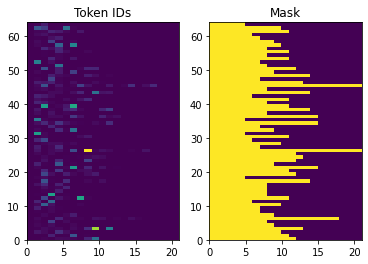

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

# Encoder


In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                   embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                         # Return the sequence and state
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        # The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)

        # The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)

        # 4. Returns the new sequence and its state.
        return output, state

# Create Attention Layer

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        w1_query = self.W1(query)
        w2_key = self.W2(value)
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True,
        )
        return context_vector, attention_weights


# Decoder layer

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru= tf.keras.layers.GRU(self.dec_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

        # For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)


class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any


class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any


def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    # Step 2. Process one step with the RNN
    rnn_output,state = self.gru(vectors, initial_state=state)

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    return DecoderOutput(logits, attention_weights), state


In [ ]:
Decoder.call = call

# Training

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)


class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
                 input_text_processor,
                 output_text_processor,
                 use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                          embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function

    def train_step(self, inputs):
        # .shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

    # Implement preprocessing step to:
    # Receive a batch of input_text, target_text from the tf.data.Dataset.
    # Convert those raw text inputs to token-embeddings and masks.
    def _preprocess(self, input_text, target_text):
        # Convert the text to token IDs
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)
        # Convert IDs to masks.
        input_mask = input_tokens != 0

        target_mask = target_tokens != 0
        return input_tokens, input_mask, target_tokens, target_mask

    # the function The _train_step:
    # Run the encoder on the input_tokens to get the encoder_output and encoder_state.
    # Initialize the decoder state and loss.
    # Loop over the target_tokens:
    #   Run the decoder one step at a time.
    #   Calculate the loss for each step.
    # Accumulate the average loss.
    # Calculate the gradient of the loss and use the optimizer to apply updates to the model's trainable_variables.

    def _train_step(self, inputs):
        input_text, target_text = inputs

        (input_tokens, input_mask,
         target_tokens, target_mask) = self._preprocess(input_text, target_text)

        max_target_length = tf.shape(target_tokens)[1]

        with tf.GradientTape() as tape:
            # Encode the input
            enc_output, enc_state = self.encoder(input_tokens)

            # Initialize the decoder's state to the encoder's final state.
            # This only works if the encoder and decoder have the same number of
            # units.
            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in tf.range(max_target_length-1):
                # Pass in two tokens from the target sequence:
                # 1. The current input to the decoder.
                # 2. The target for the decoder's next prediction.
                new_tokens = target_tokens[:, t:t+2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                       enc_output, dec_state)
                loss = loss + step_loss

            # Average the loss over all non padding tokens.
            average_loss = loss / \
                tf.reduce_sum(tf.cast(target_mask, tf.float32))

        # Apply an optimization step
        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        # Return a dict mapping metric names to current value
        return {'batch_loss': average_loss}

    # The _loop_step method, added below, executes the decoder and calculates the incremental loss and new decoder state (dec_state).

    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

        # Run the decoder one step.
        decoder_input = DecoderInput(new_tokens=input_token,
                                     enc_output=enc_output,
                                     mask=input_mask)

        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

        # `self.loss` returns the total for non-padded tokens
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)

        return step_loss, dec_state

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)

class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
# SET INPUT AND OUTPUT PROCESSOR
input_text_processor = twi_tokenizer
output_text_processor = french_tokenizer

# set Hyerperameters
embedding_dim = 256
units = 1024

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)
# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)
train_translator.use_tf_function = True

In [ ]:
train_translator.fit(trained_dataset, epochs=20,
                     callbacks=[batch_loss])

Epoch 1/50
318/318 [==============================] - 109s 315ms/step - batch_loss: 4.6108
Epoch 2/50
318/318 [==============================] - 101s 316ms/step - batch_loss: 3.4342
Epoch 3/50
318/318 [==============================] - 100s 313ms/step - batch_loss: 2.7309
Epoch 4/50
318/318 [==============================] - 98s 307ms/step - batch_loss: 2.1572
Epoch 5/50
318/318 [==============================] - 96s 303ms/step - batch_loss: 1.6228
Epoch 6/50
318/318 [==============================] - 97s 304ms/step - batch_loss: 1.1613
Epoch 7/50
318/318 [==============================] - 96s 301ms/step - batch_loss: 0.7941
Epoch 8/50
318/318 [==============================] - 98s 307ms/step - batch_loss: 0.5165
Epoch 9/50
318/318 [==============================] - 99s 311ms/step - batch_loss: 0.3207
Epoch 10/50
318/318 [==============================] - 97s 305ms/step - batch_loss: 0.1911
Epoch 11/50
318/318 [==============================] - 98s 309ms/step - batch_loss: 0.1115
Epoch

Text(0, 0.5, 'CE/token')

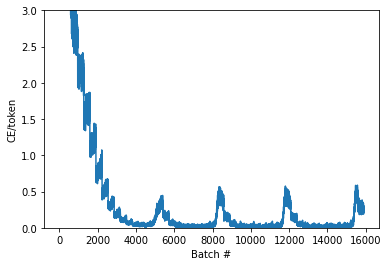

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

# Translator

In [ ]:
class Translator(tf.Module):

    def __init__(self, encoder, decoder, input_text_processor,
                 output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros(
            [index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

    def tokens_to_text(self, result_tokens):
        result_text_tokens = self.output_token_string_from_index(
            result_tokens)
        result_text = tf.strings.reduce_join(result_text_tokens,
                                             axis=1, separator=' ')
        result_text = tf.strings.strip(result_text)
        return result_text

    def sample(self, logits, temperature):
        token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
        logits = tf.where(self.token_mask, -np.inf, logits)

        if temperature == 0.0:
            new_tokens = tf.argmax(logits, axis=-1)
        else:
            logits = tf.squeeze(logits, axis=1)
            new_tokens = tf.random.categorical(logits/temperature,
                                               num_samples=1)

        return new_tokens

    def translate(self,
                  input_text, *,
                  max_length=50,
                  return_attention=True,
                  temperature=1.0):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)

        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)

        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)

        for _ in range(max_length):
            dec_input = DecoderInput(new_tokens=new_tokens,
                                     enc_output=enc_output,
                                     mask=(input_tokens != 0))

            dec_result, dec_state = self.decoder(dec_input, state=dec_state)

            attention.append(dec_result.attention_weights)

            new_tokens = self.sample(dec_result.logits, temperature)

            # If a sequence produces an `end_token`, set it `done`
            done = done | (new_tokens == self.end_token)
            # Once a sequence is done it only produces 0-padding.
            new_tokens = tf.where(done, tf.constant(
                0, dtype=tf.int64), new_tokens)

            # Collect the generated tokens
            result_tokens.append(new_tokens)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Convert the list of generates token ids to a list of strings.
        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)

        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def __call__(self, input_text):
        return self.translate(input_text)

In [ ]:
# instantiate a translator
translate = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
# Run it on a simple input:
%%time
input_text = tf.constant([
    'Yɛn agyanom Nyankopɔn .', # "Dieu de nos pères."
    'Eyi ne m’asetra .', # "C'est ma vie.""
])

result = translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

nous sommes de notre ressources .
c est la norme .

CPU times: user 19.1 s, sys: 643 ms, total: 19.7 s
Wall time: 21.1 s


In [ ]:
# set up a function to plot attention weights
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_start_and_end_tokens(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

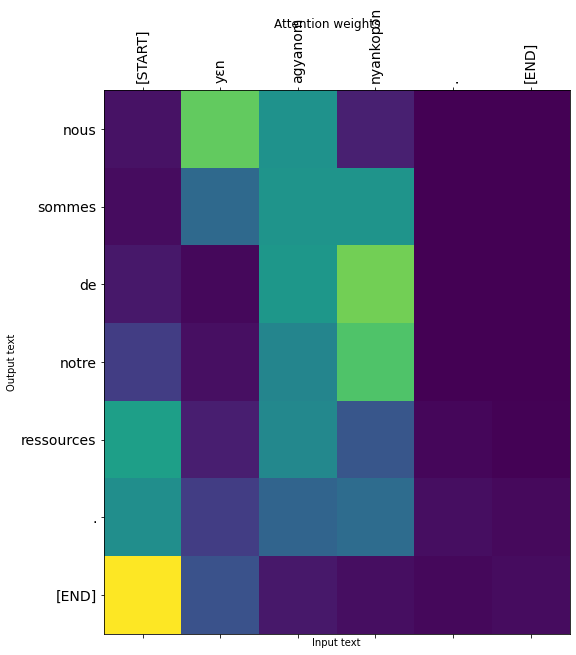

In [ ]:
# verify plot attention
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

# Save Model

In [ ]:
tf.saved_model.save(translate, '/content/drive/MyDrive/tw_fr_seq2seq_translator',
                    signatures={'serving_default': translate.__call__})

In [ ]:
reloaded = tf.saved_model.load('/content/drive/MyDrive/tw_fr_seq2seq_translator')
result = reloaded(input_text)